<a href="https://colab.research.google.com/github/MADESH938/MADESHr/blob/main/SFSMcodefile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting SFSM sequential inversion (Crank-Nicolson forward model)...
Saved results to file4clean_with_flux.csv


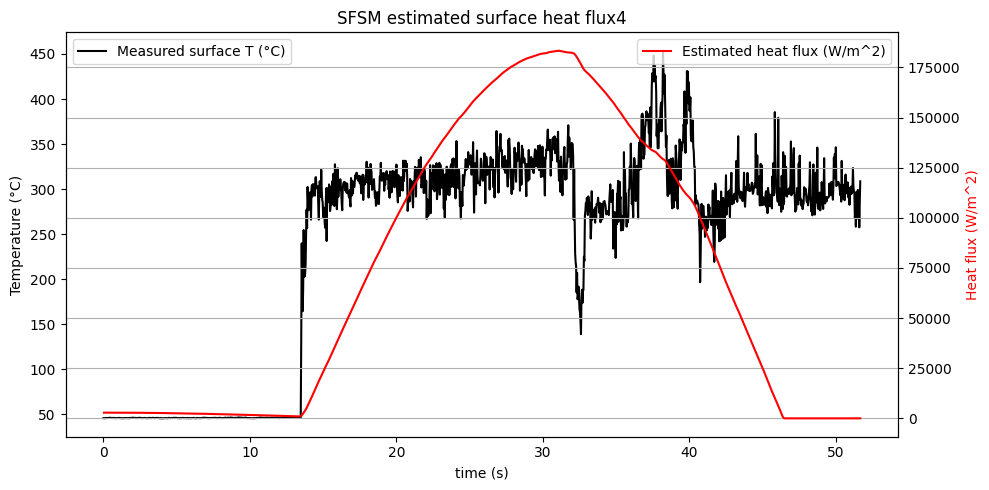

In [ ]:
# Clean SFSM implementation (Crank-Nicolson forward solver + sequential inversion for surface flux)
# - Input CSV must contain: "time_s" (s) and "temperature_C" (°C)
# - Output CSV will be INPUTNAME_with_flux.csv with column 'heat_flux_w_per_m2'
#
# Requirements: numpy, pandas, scipy
# pip install numpy pandas scipy

import numpy as np
import pandas as pd
import math
import os
from scipy.linalg import solve
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# ---------------- USER PARAMETERS ----------------
INPUT_CSV = "file4clean.csv"   # change to your cleaned file
OUTPUT_CSV = os.path.splitext(INPUT_CSV)[0] + "_with_flux.csv"

# Material (AISI 4140 typical)
k = 38.0        # W/(m·K)
rho = 7850.0    # kg/m^3
cp = 460.0      # J/(kg·K)
alpha = k / (rho * cp)

# Spatial discretization (1-D depth into tool)
domain_depth_m = 0.002   # 2 mm (you agreed)
nx = 50                  # nodes (>= 30 recommended)
dx = domain_depth_m / (nx - 1)

# Minimization & flux bounds
q_min = 0.0              # flux lower bound (W/m^2)
q_max = 2e7              # flux upper bound (W/m^2) — adjust if you expect higher
smooth_lambda = 1e-5     # small penalty weight on (q - q_prev)^2 to discourage wild jumps
                         # set to 0 to disable

# Optional: final smoothing of the recovered flux (moving average)
apply_post_smoothing = True
smooth_window = 5        # must be odd; if <=1 no smoothing

# Safety checks
if nx < 3:
    raise ValueError("nx must be >= 3")

# ---------------- Helper: build second-derivative operator L with Neumann/flux adjustments -------------
# We create L such that d2T/dx2 = L @ T + S(q), where S(q) is a vector containing the flux contribution only at index 0.
# For interior nodes i=1..nx-2: standard 1/dx^2 * (T[i-1] - 2T[i] + T[i+1])
# For surface node i=0: using ghost-node to impose -k dT/dx = q -> yields:
#    d2T/dx2 at i=0 = (2*T1 - 2*T0)/dx^2  +  2*q/(k*dx)
# So L[0,0] = -2/dx^2, L[0,1] = 2/dx^2 and S0 = 2*q/(k*dx)
# For last node i=nx-1 (insulated dT/dx=0): d2T/dx2 = (2*T[n-2] - 2*T[n-1]) / dx^2
def build_L(nx, dx):
    L = np.zeros((nx, nx), dtype=float)
    invdx2 = 1.0 / (dx * dx)
    # interior
    for i in range(1, nx - 1):
        L[i, i - 1] = 1.0 * invdx2
        L[i, i]     = -2.0 * invdx2
        L[i, i + 1] = 1.0 * invdx2
    # surface (i=0)
    L[0, 0] = -2.0 * invdx2
    L[0, 1] =  2.0 * invdx2
    # insulated far end (i=nx-1): use T_{n} ~ T_{n-2} trick
    L[-1, -2] =  2.0 * invdx2
    L[-1, -1] = -2.0 * invdx2
    return L

L = build_L(nx, dx)

# ---------------- Crank-Nicolson single-step solver with flux source ----------------
# For each time step dt, given T_n (vector length nx) and constant q over the interval,
# compute T_{n+1} solving:
#   (I - 0.5*dt*alpha*L) T_{n+1} = (I + 0.5*dt*alpha*L) T_n + dt*alpha * S(q)
# where S(q) is zero vector except S[0] = 2*q/(k*dx)
I = np.eye(nx)
def S_from_q(q):
    S = np.zeros(nx, dtype=float)
    S[0] = 2.0 * q / (k * dx)
    return S

def crank_nicolson_step(Tn, q, dt):
    if dt <= 0:
        return Tn.copy()
    B = I - 0.5 * dt * alpha * L
    C = I + 0.5 * dt * alpha * L
    rhs = C.dot(Tn) + dt * alpha * S_from_q(q)
    Tnp1 = solve(B, rhs)   # solve linear system
    return Tnp1

# ---------------- Load data ----------------
df = pd.read_csv(INPUT_CSV)
if 'time_s' not in df.columns or 'temperature_C' not in df.columns:
    raise ValueError("Input CSV must contain 'time_s' and 'temperature_C' columns exactly.")

time = np.asarray(df['time_s'], dtype=float)
T_meas = np.asarray(df['temperature_C'], dtype=float)

# Ensure sorted by time
order = np.argsort(time)
time = time[order]
T_meas = T_meas[order]

n = len(time)
if n < 2:
    raise ValueError("Need at least two samples.")

# Reserve arrays for flux per interval
q_intervals = np.zeros(n - 1, dtype=float)

# Initialize temperature profile to first measured temperature (uniform)
T_profile = np.ones(nx, dtype=float) * T_meas[0]

# Sequential inversion: for each interval [i -> i+1], find q that makes simulated surface at t_{i+1} match measured
print("Starting SFSM sequential inversion (Crank-Nicolson forward model)...")
for i in range(n - 1):
    t0 = time[i]
    t1 = time[i + 1]
    dt_interval = t1 - t0
    if dt_interval <= 0:
        q_intervals[i] = 0.0
        continue

    T_target = T_meas[i + 1]

    # Optional smoothness prior: penalize large jumps from previous q
    q_prev = q_intervals[i - 1] if i >= 1 else None

    # Define objective: squared error between simulated surface temp and measured target
    def objective(q):
        q = float(q)
        T_end = crank_nicolson_step(T_profile, q, dt_interval)
        Tsurf = T_end[0]
        err = (Tsurf - T_target) ** 2
        if (q_prev is not None) and (smooth_lambda > 0):
            err += smooth_lambda * (q - q_prev) ** 2
        return err

    # Minimize scalar function between bounds q_min..q_max
    res = minimize_scalar(objective, bounds=(q_min, q_max), method='bounded',
                          options={'xatol': 1e-2, 'maxiter': 80})
    q_opt = float(res.x)
    q_intervals[i] = q_opt

    # Update profile to T_{n+1} using that q
    T_profile = crank_nicolson_step(T_profile, q_opt, dt_interval)

# Align flux to timestamps: flux at index j corresponds to interval (j-1 -> j). First sample has NaN.
flux_aligned = np.empty(n, dtype=float)
flux_aligned[:] = np.nan
flux_aligned[1:] = q_intervals

# Optional post-smoothing
if apply_post_smoothing and smooth_window > 1:
    w = smooth_window if smooth_window % 2 == 1 else smooth_window + 1
    # simple moving average ignoring NaNs at start
    q_valid = flux_aligned[1:].copy()
    # pad edges to preserve length
    pad = (w - 1) // 2
    q_padded = np.pad(q_valid, (pad, pad), mode='edge')
    kernel = np.ones(w) / w
    q_smooth = np.convolve(q_padded, kernel, mode='valid')
    flux_aligned[1:] = q_smooth

# Save results
out_df = pd.DataFrame({
    'time_s': time,
    'temperature_C': T_meas,
    'heat_flux_w_per_m2': flux_aligned
})
out_df.to_csv(OUTPUT_CSV, index=False)
print(f"Saved results to {OUTPUT_CSV}")

# Quick diagnostic plot
try:
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.plot(time, T_meas, '-k', label='Measured surface T (°C)')
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('Temperature (°C)', color='k')
    ax2 = ax1.twinx()
    ax2.plot(time, flux_aligned, '-r', label='Estimated heat flux (W/m^2)')
    ax2.set_ylabel('Heat flux (W/m^2)', color='r')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title('SFSM estimated surface heat flux4')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
except Exception:
    pass

# Done


Error: The file 'your_data.csv' was not found.
Please make sure the file is in the same directory as the script,
or provide the full path to the file.
3D visualization has been saved as 3d_visualization.png


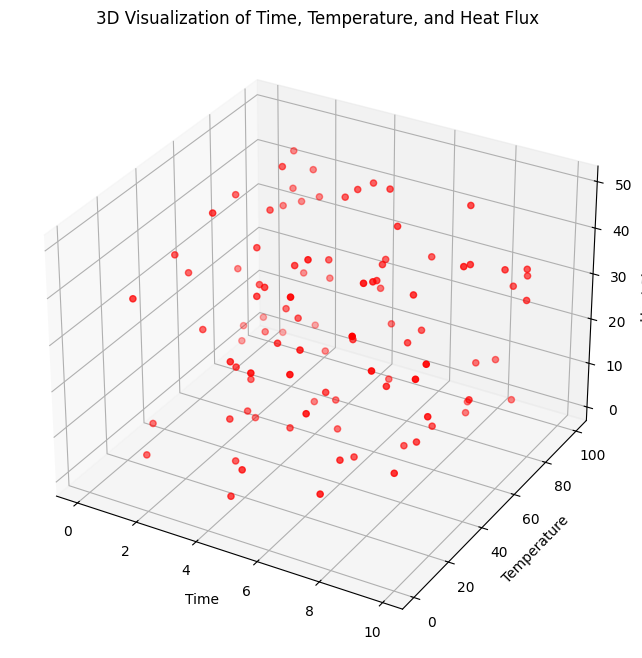

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create a dummy CSV file for demonstration
data = {
    'time_s': np.arange(0, 10, 0.1),
    'temperature_C': np.random.rand(100) * 100,
    'heat_flux_w_per_m2': np.random.rand(100) * 50
}
df = pd.DataFrame(data)
df.to_csv('/content/file5clean_with_flux.csv', index=False)

# Load your data from the CSV file
# Make sure to replace 'your_data.csv' with the actual name of your file
try:
    df = pd.read_csv('/content/file5clean_with_flux.csv.csv')
except FileNotFoundError:
    print("Error: The file 'your_data.csv' was not found.")
    print("Please make sure the file is in the same directory as the script,")
    print("or provide the full path to the file.")
    exit()


# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(df['time_s'], df['temperature_C'], df['heat_flux_w_per_m2'], c='r', marker='o')

# Set labels
ax.set_xlabel('Time')
ax.set_ylabel('Temperature')
ax.set_zlabel('Heat Flux')

# Set title
plt.title('3D Visualization of Time, Temperature, and Heat Flux')

# Save the plot
plt.savefig('3d_visualization.png')

print("3D visualization has been saved as 3d_visualization.png")